In [39]:
import numpy as np
import pandas as pd
import math
import operator
import itertools 
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import requests
from io import BytesIO

In [2]:
def norma(a):
  a = np.array(a)
  at = a.T
  return math.sqrt(np.dot(a,at)) 

In [3]:
def normalizar(a):
  a = np.array(a)
  return a/norma(a)

In [4]:
def dist(a,b):
  a = np.array(a)
  b = np.array(b)
  return norma(b-a)

In [5]:
def projecao(a,b):
  a = np.array(a)
  b = np.array(b)
  return np.dot(a,b)/np.dot(a,a)*a

In [6]:
def cos(a,b):
    p = projecao(a,b)
    return norma(p)/norma(b)

In [7]:
def avarage_vector(a):
    a = np.array(a)
    return np.mean(a,axis=0)

In [10]:
def tratar_df(df): # trata o dataframe, excluindo colunas inuteis.
    df = df.loc[:, 'pace':'goalkeeping_reflexes']
    df = df.fillna(0)
    df = df.fillna(' ')
    df = df.to_numpy()
    return df

In [11]:
def gerar_dfs(df, pos):
    dfs = []
    for i in pos: 
        dfs.append(avarage_vector(tratar_df(df[df['club_position'] == i])))
    return dfs

In [12]:
def predict(dict, pos_nomes, player):
    coss = []
    for p in pos_nomes:
        coss.append(cos(player[0], dict[p]))
    pos = {pos_nomes[i]:coss[i] for i in range(len(pos_nomes))}
    return max(pos, key=pos.get)


In [13]:
def team_over(df, team, ata, mei, deff):
    over = [0,0,0,0]
    over_ = [0,0,0]
    df = df[df['club_name']==team]
    df = df[df['club_position'] != 'RES']
    for _,player in df.iterrows():
        if any(item in player['player_positions'] for item in ata):
            over[0] = over[0] + player['overall']
            over_[0] = over_[0] + 1
        if any(item in player['player_positions'] for item in mei):
            over[1] = over[1] + player['overall']
            over_[1] = over_[1] + 1
        if any(item in player['player_positions'] for item in deff):
            over[2] = over[2] + player['overall']
            over_[2] = over_[2] + 1
    over[0] = over[0]/over_[0]
    over[1] = over[1]/over_[1]
    over[2] = over[2]/over_[2]
    over[3] = (over[0]+over[1]+over[2])/3
    over.append(team)
    return over

In [14]:
def league_over(df, league, ata, mei, deff):
    l_teams = df[df['league_name'] == league]
    l_over = []
    for team in l_teams['club_name'].unique():
        te = team_over(df, team, ata, mei, deff)
        te = te[:-1]
        l_over.append(te)
    l_over = np.array(l_over).mean(0)
    l_over = l_over.tolist()
    l_over.append(league)
    return l_over

In [15]:
def recommend(df, player):
    player_df = df[df['short_name'] == player]
    pos = player_df['player_positions'].str.split(', ').tolist()[0]
    l = []
    for p in pos:
        l.append(player_dist(df, player, p))
    return dict(zip(pos, l))

In [16]:
def player_dist(df, player, pos):
    player_df = df[df['short_name'] == player]
    dfs = df.drop(df[df['short_name'] == player].index)	# remove o player do df
    dfs = dfs[dfs['player_positions'].str.contains(pos)]	# os players que possuem a mesma posição
    dfs_ = tratar_df(dfs)
    player_df = tratar_df(player_df)
    dists = []
    for i in dfs_:
        dists.append(cos(i, player_df[0])/dist(i, player_df[0]))
    dists = dict(zip(dfs['short_name'], dists))  
    dists = dict(sorted(dists.items(), key = lambda x: x[1], reverse = True))
    dists = dict(itertools.islice(dists.items(), 5))
    return dists

In [17]:
def plotar_comp(team, league):
    posicoes = ["Ataque", "Meio", "Defesa", "Media Geral"]
    team_ = team[:-1]
    league_ = league[:-1]
    plt.rcParams['figure.figsize'] = (13,9)
    plt.plot(posicoes, team_, label = team[4], color = 'blue', marker = 'o')
    plt.plot(posicoes, league_, label = league[4], color = 'red', marker = 'o')
    plt.yticks(np.arange(min(league_ +  team_)-3, max(league_ + team_)+3, 0.5))
    plt.title("Comparação entre a equipe e a liga")
    plt.xlabel("Posições")
    plt.ylabel("Overall Médio")
    plt.legend()
    plt.show()

In [18]:
ata_pos = ["ST", "LF", "CF", "RF", "LW", "RW"] # posicoes do atacante
mei_pos = ["CAM", "CM", "CDM", "LM", "RM"] # posicoes do meio
def_pos = ["CB", "LB", "RB", "LWB", "RWB", "GK"] # posicoes do defesa
pos_nomes = ata_pos + mei_pos + def_pos
df = pd.read_csv('players_22.csv')
pos_df = gerar_dfs(df, pos_nomes)
pos_dict = dict(zip(pos_nomes, pos_df))

C:\Users\bieli\AppData\Local\Temp/ipykernel_21796/1556863144.py:5: DtypeWarning: Columns (25,108) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('players_22.csv')


In [19]:
tottenham = team_over(df, 'Tottenham Hotspur', ata_pos, mei_pos, def_pos)
print(tottenham)
pl = league_over(df, 'English Premier League', ata_pos, mei_pos, def_pos)
print(pl)

[79.42857142857143, 79.83333333333333, 79.54545454545455, 79.60245310245311, 'Tottenham Hotspur']
[76.46068362193363, 76.97985556110557, 76.69378843378844, 76.71144253894252, 'English Premier League']


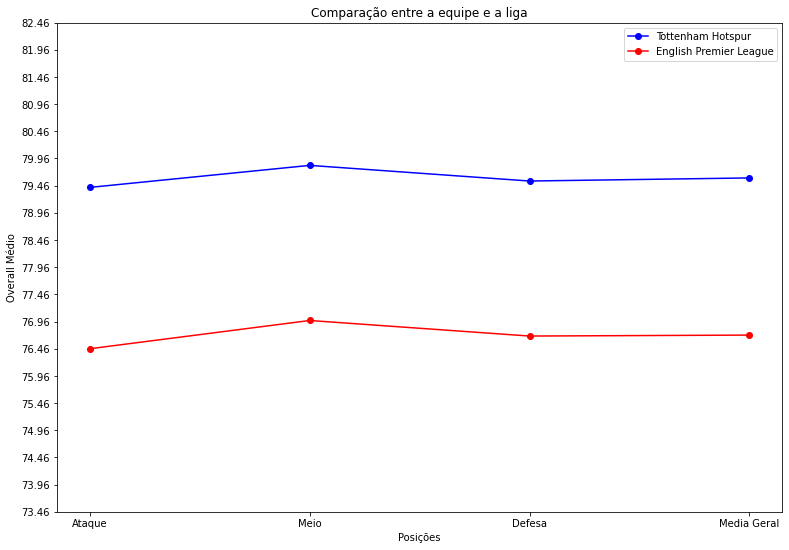

In [20]:
plotar_comp(tottenham, pl)

In [139]:
def plotar_recommend(df, player):
    titulos = ["Nosso Jogador", "Jogador Recomendado 1", "Jogador Recomendado 2", "Jogador Recomendado 3"]
    imgs = []
    recomendados = recommend(df, player)
    keys = list(recomendados.keys())
    rows = keys.__len__()
    cols = 4
    nomes = []
    for i in keys:
        nomes.append(i)
        p = df[df['short_name'] == player]
        p = p['player_face_url'].values[0]
        respic = requests.get(p)
        pimg = Image.open(BytesIO(respic.content))
        imgs.append(pimg)
        cont = 0
        for j in list(recomendados[i].keys()):
            nomes.append(j)
            r = df[df['short_name'] == j]
            r = r['player_face_url'].values[0]
            r_respic = requests.get(r)
            r_pimg = Image.open(BytesIO(r_respic.content))
            imgs.append(r_pimg)
            cont = cont + 1
            if cont > 2:
                break
    fig = plt.figure(figsize=(10,7))
    for i in range(rows):
        for j in range(cols):
            fig.add_subplot(rows, cols, i*cols+j+1)
            plt.imshow(imgs[i*cols+j])
            if j == 0:
                plt.title(player + " \n POS: " + keys[i])
            else:
                plt.title('Jogador Recomendado ' + str(j) + " \n " + nomes[i*cols+j])
            plt.axis('off')


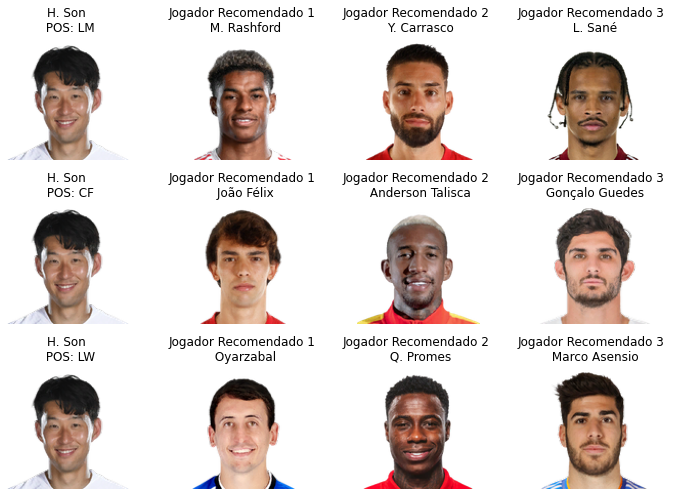

In [143]:
plotar_recommend(df, "H. Son")